In [27]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pyarabic.araby import strip_tashkeel


In [12]:
df = pd.read_excel("E:\ComputerScience\GP_project\HAQA.xlsx")
df = df.drop(columns=['Unnamed: 3','Unnamed: 4','Unnamed: 5'])
df.rename(columns={'Question_Text': 'question','Hadith_Matn': 'context','Answer-Instances ':'answers'}, inplace=True)
df.head()

c:\Users\DELL-MCC\anaconda3\envs\rag\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,question,context,answers
0,كيف نعبد الله؟,مَن عمِلَ عمَلاً لَيْسَ عَلَيهِ أمْرُنا فَهُو...,مَن عمِلَ عمَلاً لَيْسَ عَلَيهِ أمْرُنا فَهُو...
1,هل نعبد الله خوفا وطمعا؟,أسألُ اللهَ الجنّة وأعوذ بِهِ مِن النّار,أسألُ اللهَ الجنّة وأعوذ بِهِ مِن النّار
2,ما هو الإحسان في العبادة؟,الإحسانُ أَنْ تعبُدَ اللهَ كأنّك تراه فإن لَم...,أَنْ تعبُدَ اللهَ كأنّك تراه فإن لَمْ تكن تراه...
3,ما معنى لا إله إلا الله؟,من قَالَ لآ إله إِلاَّ الله وكَفَرَ بِمَا يُع...,من قَالَ لآ إله إِلاَّ الله وكَفَرَ بِمَا يُع...
4,ما هو التوحيد في صفات الله؟,ينزِلُ ربُّنا تبارك وتعالى فِي كلّ ليلةٍ إِلَى...,ينزِلُ ربُّنا تبارك وتعالى فِي كلّ ليلةٍ إِلَى...


In [13]:
len(df)

1595

In [14]:
df['question'] = df['question'].apply(lambda x: strip_tashkeel(x))
df['context'] = df['context'].apply(lambda x: strip_tashkeel(x))
df['answers'] = df['answers'].apply(lambda x: strip_tashkeel(x))

In [15]:
def clean_text(text):
    text = re.sub(r'<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [16]:
df[['question', 'context', 'answers']] = df[['question', 'context', 'answers']].applymap(clean_text)

C:\Users\DELL-MCC\AppData\Local\Temp\ipykernel_8424\3417558923.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['question', 'context', 'answers']] = df[['question', 'context', 'answers']].applymap(clean_text)


In [17]:
df.drop_duplicates(subset=['question', 'context'], keep='first', inplace=True)
len(df)

1595

In [18]:
indices_without_answers = []

for index, row in df.iterrows():
    if not row['answers']:
        indices_without_answers.append(index)

# Print the indices of rows without answers
print("Indices of rows without answers:", indices_without_answers)
df_cleaned = df.drop(indices_without_answers ,inplace=True)

Indices of rows without answers: [219]


In [19]:
len(df)

1594

In [20]:
def find_answer_start(row):
    answer = row['answers']
    context = row['context']
    answer_start = context.find(answer)
    return answer_start

In [21]:
def preprocess_df(df):
    df['answers'] = df.apply(lambda row: {'answer_start': [find_answer_start(row)], 'text': [row['answers']]}, axis=1)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    return df

In [22]:
df = preprocess_df(df)

In [23]:
first_column = df.pop('answers')  # Remove the first column and store it
df['answers'] = first_column 

In [24]:
df.head()

,question,context,answers
0,كيف نعبد الله,من عمل عملا ليس عليه أمرنا فهو رد,"{'answer_start': [0], 'text': ['من عمل عملا لي..."
1,هل نعبد الله خوفا وطمعا,أسأل الله الجنة وأعوذ به من النار,"{'answer_start': [0], 'text': ['أسأل الله الجن..."
2,ما هو الإحسان في العبادة,الإحسان أن تعبد الله كأنك تراه فإن لم تكن تراه...,"{'answer_start': [8], 'text': ['أن تعبد الله ك..."
3,ما معنى لا إله إلا الله,من قال لآ إله إلا الله وكفر بما يعبد من دون ال...,"{'answer_start': [0], 'text': ['من قال لآ إله ..."
4,ما هو التوحيد في صفات الله,ينزل ربنا تبارك وتعالى في كل ليلة إلى السماء ا...,"{'answer_start': [0], 'text': ['ينزل ربنا تبار..."


In [25]:
context_lengths = [len(example["context"]) for i,example in df.iterrows()]
question_lengths = [len(example["question"]) for i,example in df.iterrows()]

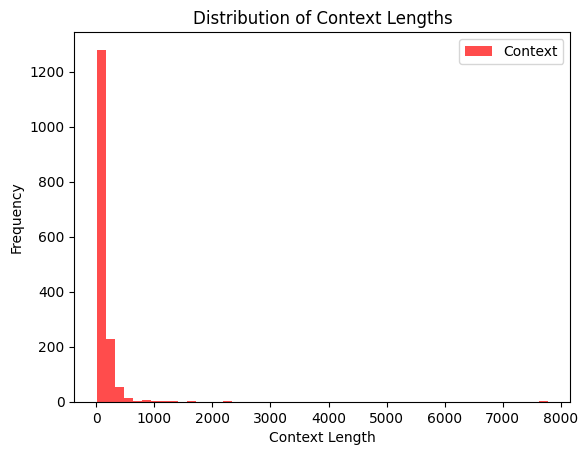

In [28]:
plt.hist(context_lengths, bins=50, color='red', alpha=0.7, label='Context')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Context Lengths')
plt.show()

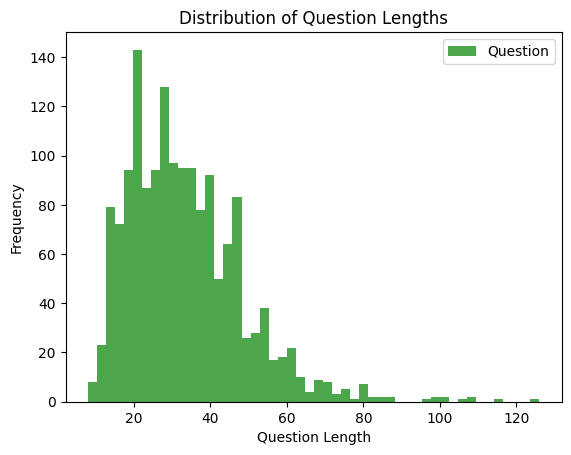

In [29]:
plt.hist(question_lengths, bins=50, color='green', alpha=0.7, label='Question')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Question Lengths')
plt.show()

In [30]:
max_context_length = max(context_lengths)
max_question_length = max(question_lengths)

print(f"Max Context Length: {max_context_length}")
print(f"Max Question Length: {max_question_length}")

Max Context Length: 7777
Max Question Length: 126


In [31]:
df.insert(0, 'id', range(1, len(df) + 1))

In [32]:
df.head()

,id,question,context,answers
0,1,كيف نعبد الله,من عمل عملا ليس عليه أمرنا فهو رد,"{'answer_start': [0], 'text': ['من عمل عملا لي..."
1,2,هل نعبد الله خوفا وطمعا,أسأل الله الجنة وأعوذ به من النار,"{'answer_start': [0], 'text': ['أسأل الله الجن..."
2,3,ما هو الإحسان في العبادة,الإحسان أن تعبد الله كأنك تراه فإن لم تكن تراه...,"{'answer_start': [8], 'text': ['أن تعبد الله ك..."
3,4,ما معنى لا إله إلا الله,من قال لآ إله إلا الله وكفر بما يعبد من دون ال...,"{'answer_start': [0], 'text': ['من قال لآ إله ..."
4,5,ما هو التوحيد في صفات الله,ينزل ربنا تبارك وتعالى في كل ليلة إلى السماء ا...,"{'answer_start': [0], 'text': ['ينزل ربنا تبار..."


In [33]:
df.to_csv('preprocessed_data.csv', index=False) 